<a href="https://colab.research.google.com/github/Erickpython/kodeCamp_5X-MachineLearning/blob/main/00_CNNs%2C_LeNet_and_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple LeNet CNN for MNIST Digit Classification

We train a Convolutional Neural Network (CNN) to recognize handwritten digits from the MNIST dataset. MNIST contains 70000 images of handwritten digits (0-9), each 28x28 pixels in grayscale.

The CNN learns to:
1. Extract features from images using convolutional layers
2. Classify digits with fully connected layers
3. Achieve ~98-99% accuracy on the test set
"""

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Use a GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# LeNet-5 (1998)
One of the first CNNs

Designed for digit recognition (MNIST)

**Architecture:**
- Conv → Pool → Conv → Pool → FC


In [ ]:
# Define a simple CNN architecture (LeNet)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # MNIST = 28x28x1
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)

        # Layer1 = 28x28x6
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Pool1 = 14x14x6
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, padding=1)

        # Layer2 = 14x14x16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Pool2 = 7x7x16
        self.fc1 = nn.Linear(16 * 7 * 7, 120)

        # FC1 = 120 flat outputs
        self.fc2 = nn.Linear(120, 10)


    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        # Flatten
        x = x.view(-1, 16 * 7 * 7)
        x = self.fc2(self.fc1(x))
        return x

# Training loop

In [ ]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10

## Transform (DATA PREPROCESSING AND LOADING)

### Transform: a series of operations to apply to each image

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),     # Convert PIL Image to PyTorch tensor (HxWxC -> CxHxW)
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize with MNIST mean and std
])

### Get the Data

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [ ]:
# DataLoader: splits dataset into batches and shuffles them
# shuffle=True: randomize order each epoch (helps prevent overfitting)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize model
model = LeNet().to(device)

In [ ]:
# Training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
def train(model, device, train_loader, optimizer, criterion, epoch):
    # Set model to training mode.
    model.train()

    train_loss = 0
    correct = 0
    total = 0
    losses = []

    # Loop through batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # data: shape of data (batch_size, 1, 28, 28)
        # target: shape of labels (batch_size,)

        # Move data to the same device as the model (GPU/CPU)
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward propagation
        pred = model(data)

        # Loss calculation
        loss = criterion(pred, target)

        # Backward propagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        losses.append(loss.item())

        # Get the predicted class (digit with highest score)
        _, predicted = pred.max(1)

        total += target.size(0)  # Add current batch size to total count
        correct += predicted.eq(target).sum().item()  # Add correct predictions to count


        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


    # Calculate the average metrics
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy, losses

In [ ]:
# Test function
def test(model, device, test_loader, criterion):
    # Switch to evaluation mode
    model.eval()

    test_loss = 0
    correct = 0
    total = 0
    losses = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward propagation
            pred = model(data)

            # Loss calculation
            loss = criterion(pred, target)

            # Metrics
            test_loss += loss.item()
            losses.append(loss.item())

            # Calculate accuracy
            _, predicted = pred.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    # Calculate average metrics
    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total

    print(f"\nTest set: Average loss: {avg_loss:.4f},"
          f"Accuracy: {correct}/{total} ({accuracy:.2f}%)\n")

    return avg_loss, accuracy, losses

In [ ]:
# Main training loop

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

train_losses_epoch_cum = []
test_losses_epoch_cum = []


for epoch in range(1, num_epochs + 1):

    train_loss, train_acc, train_losses_epoch = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc, test_losses_epoch = test(model, device, test_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_losses_epoch_cum.extend(train_losses_epoch)

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    test_losses_epoch_cum.extend(test_losses_epoch)

print("Training complete!")
print("=" * 60)

Epoch: 1 [0/60000 (0%)]	Loss: 2.291762
Epoch: 1 [6400/60000 (11%)]	Loss: 0.270519
Epoch: 1 [12800/60000 (21%)]	Loss: 0.243829
Epoch: 1 [19200/60000 (32%)]	Loss: 0.237332
Epoch: 1 [25600/60000 (43%)]	Loss: 0.083458
Epoch: 1 [32000/60000 (53%)]	Loss: 0.107373
Epoch: 1 [38400/60000 (64%)]	Loss: 0.031349
Epoch: 1 [44800/60000 (75%)]	Loss: 0.218701
Epoch: 1 [51200/60000 (85%)]	Loss: 0.124006
Epoch: 1 [57600/60000 (96%)]	Loss: 0.131410

Test set: Average loss: 0.0755,Accuracy: 9759/10000 (97.59%)

Epoch: 2 [0/60000 (0%)]	Loss: 0.015674
Epoch: 2 [6400/60000 (11%)]	Loss: 0.047691
Epoch: 2 [12800/60000 (21%)]	Loss: 0.159619
Epoch: 2 [19200/60000 (32%)]	Loss: 0.018397
Epoch: 2 [25600/60000 (43%)]	Loss: 0.079880
Epoch: 2 [32000/60000 (53%)]	Loss: 0.064410
Epoch: 2 [38400/60000 (64%)]	Loss: 0.054574
Epoch: 2 [44800/60000 (75%)]	Loss: 0.040094
Epoch: 2 [51200/60000 (85%)]	Loss: 0.028307
Epoch: 2 [57600/60000 (96%)]	Loss: 0.012785

Test set: Average loss: 0.0584,Accuracy: 9812/10000 (98.12%)

Epoch:

Training history saved to training_history.png


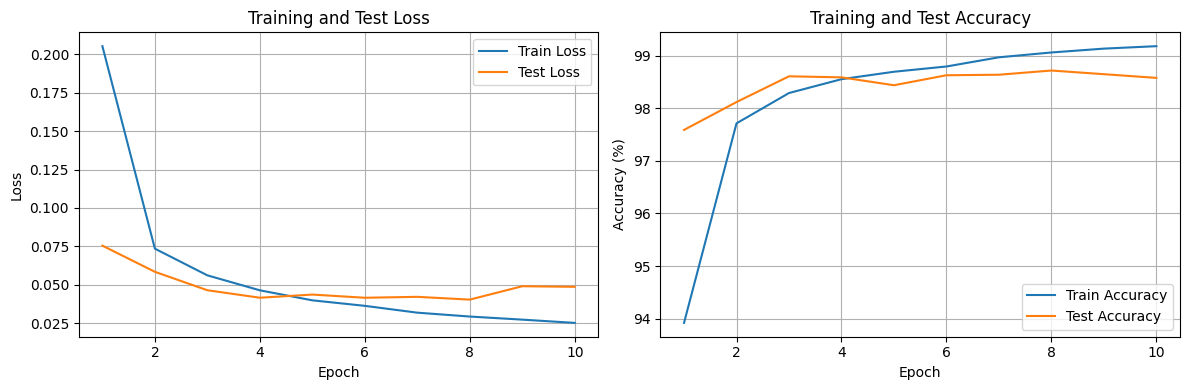

In [ ]:
# ============================================================================
# VISUALIZE TRAINING RESULTS
# ============================================================================

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# LEFT PLOT: Loss over epochs
# Loss should generally decrease over time
# If test loss starts increasing while train loss decreases, that's overfitting
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
ax1.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# RIGHT PLOT: Accuracy over epochs
# Accuracy should generally increase over time
# Large gap between train and test accuracy indicates overfitting
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig('training_history.png')  # Save the figure
print('Training history saved to training_history.png')

## **Image Visualizations**

This set of scripts visualizes the actual MNIST data and compares the trained model's predictions with the actual true values.

In [ ]:
# ============================================================================
# SAVE THE TRAINED MODEL
# ============================================================================

# Save only the model's learned parameters (weights and biases)
# To load later: model.load_state_dict(torch.load('mnist_cnn.pth'))
torch.save(model.state_dict(), 'mnist_cnn.pth')
print('Model saved to mnist_cnn.pth')
print("\nYou can now use this model to make predictions on new digit images!")

Model saved to mnist_cnn.pth

You can now use this model to make predictions on new digit images!


MNIST Visualization Script

Using device: cpu

Loading MNIST dataset...
✓ Loaded 10000 test images

----------------------------------------------------------------------
Visualization 1: Random Dataset Samples
----------------------------------------------------------------------
✓ Dataset samples saved to dataset_samples.png


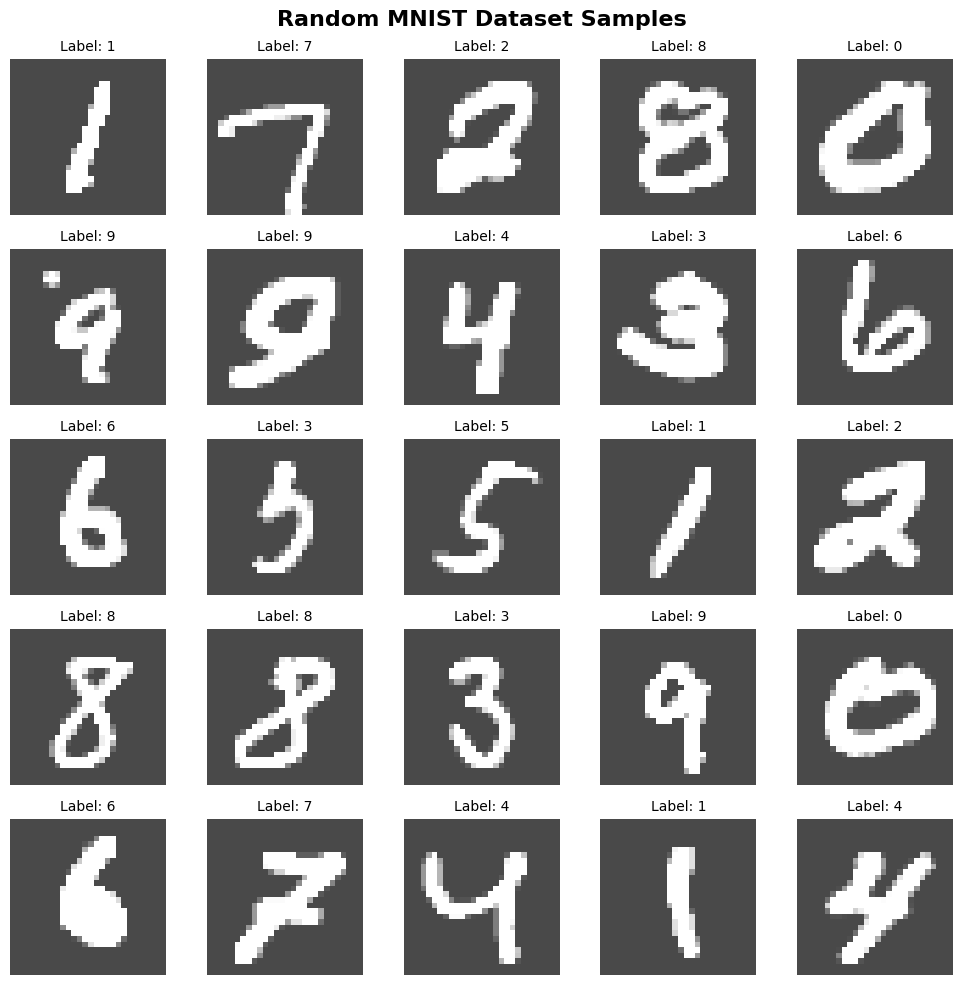


----------------------------------------------------------------------
Loading Trained Model for Predictions
----------------------------------------------------------------------
✓ Model loaded successfully from mnist_cnn.pth

----------------------------------------------------------------------
Visualization 2: Model Predictions (Mixed)
----------------------------------------------------------------------
✓ Predictions saved to predictions.png


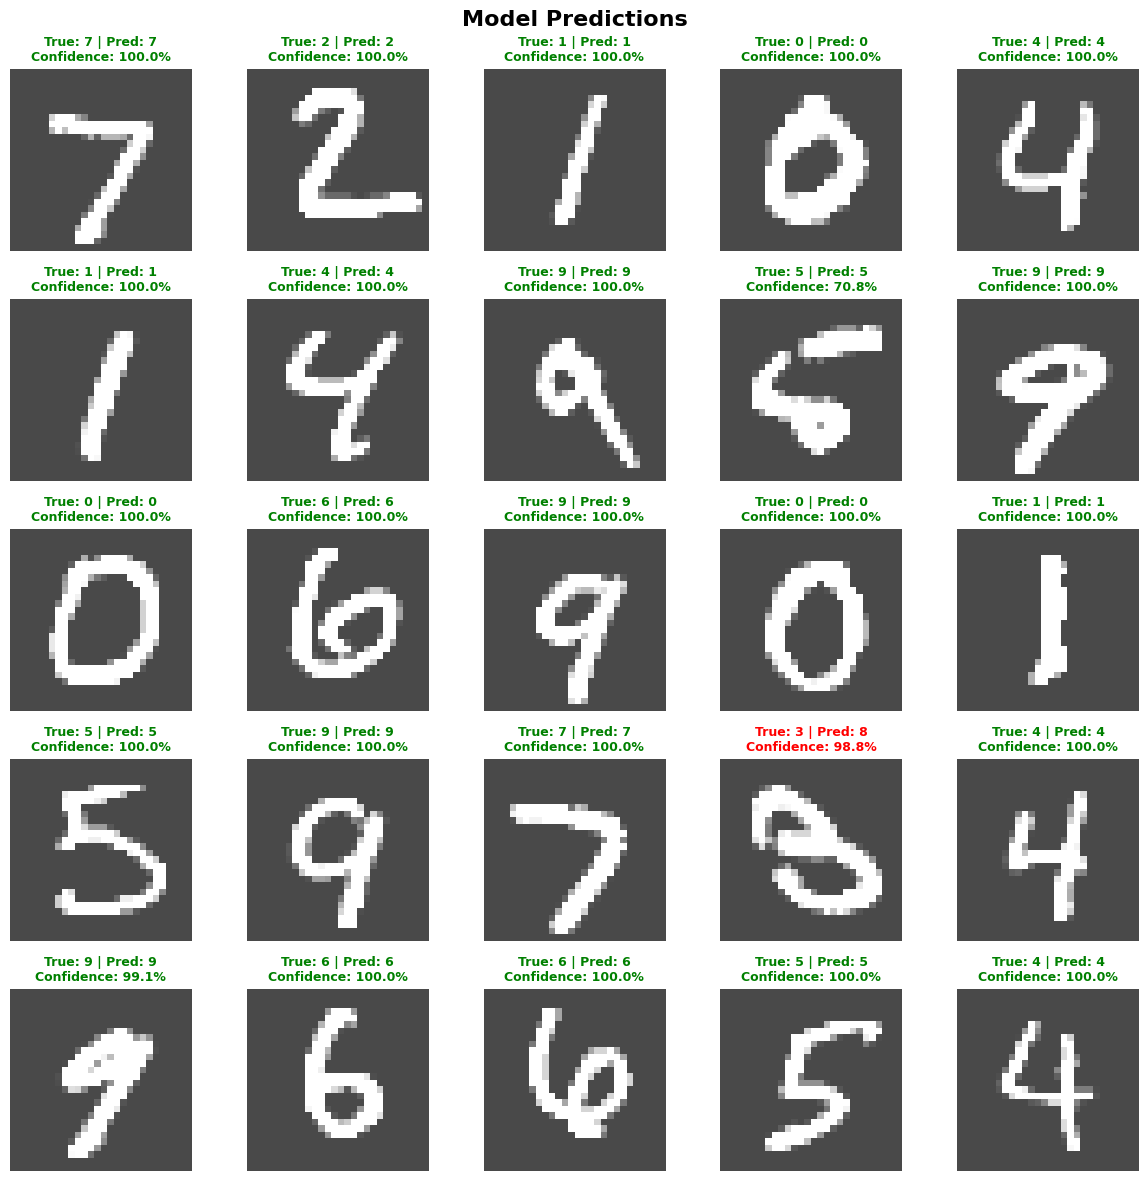


----------------------------------------------------------------------
Visualization 3: Incorrect Predictions Only
----------------------------------------------------------------------
✓ Predictions saved to predictions_incorrect.png


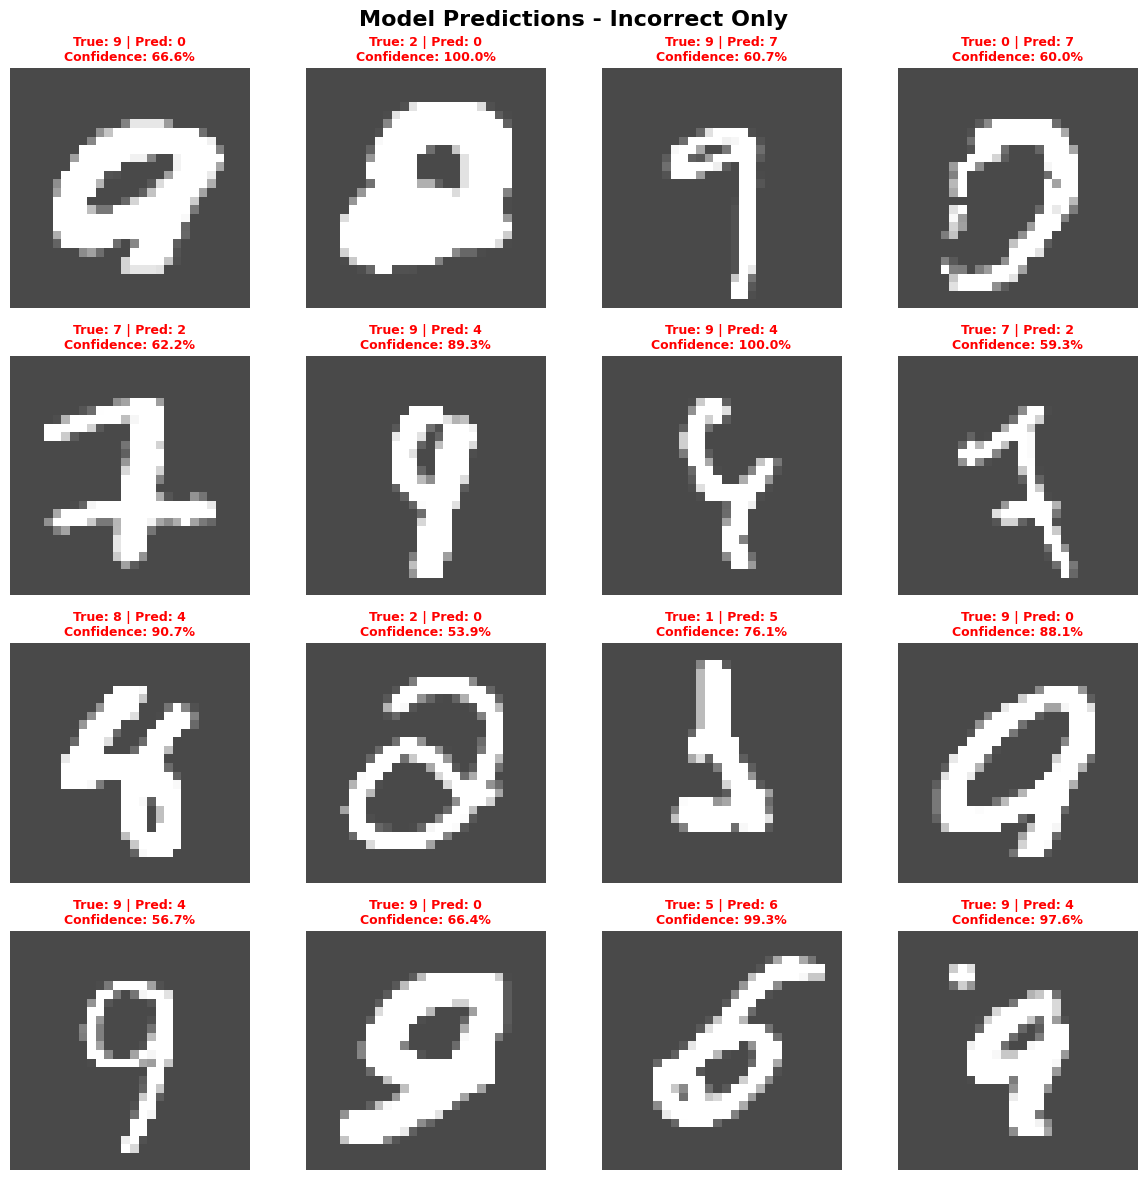


----------------------------------------------------------------------
Visualization 4: One Example Per Digit Class
----------------------------------------------------------------------
✓ One per class visualization saved to one_per_class.png


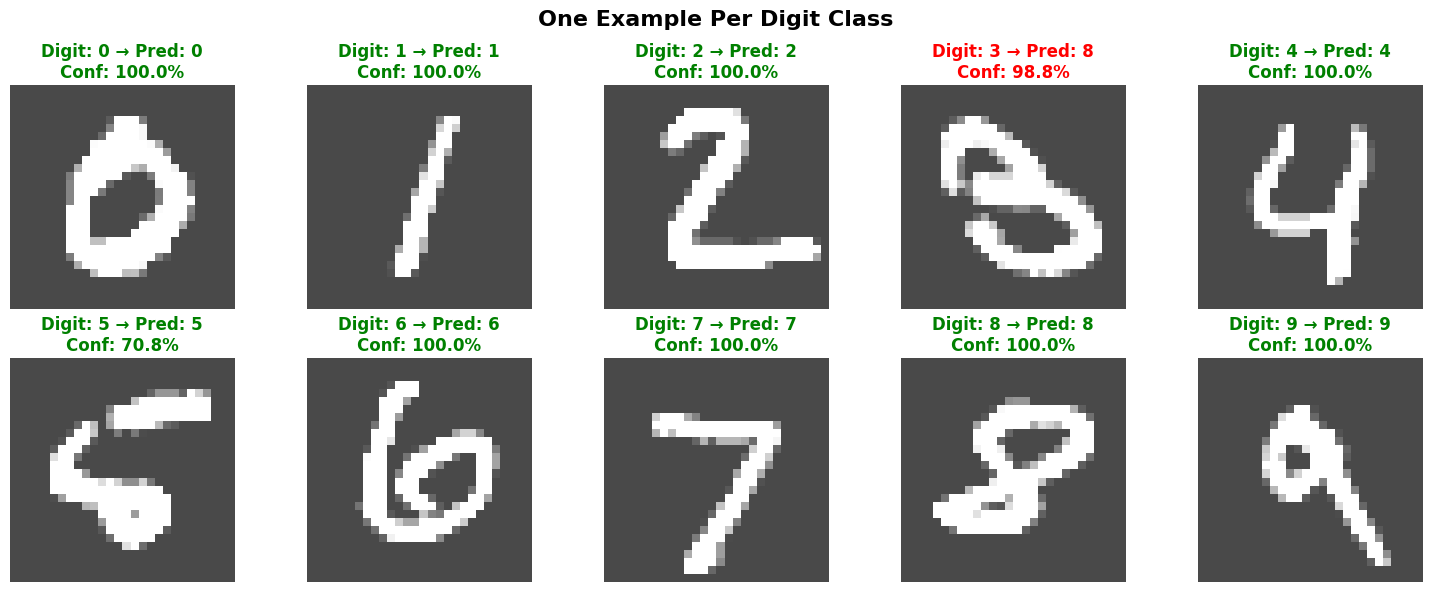


Visualization Complete!

Generated files:
  • dataset_samples.png - Random samples from MNIST
  • predictions.png - Model predictions (mixed correct/incorrect)
  • predictions_incorrect.png - Only incorrect predictions
  • one_per_class.png - One example for each digit (0-9)

Tips for interpreting results:
  • Green titles = correct predictions
  • Red titles = incorrect predictions
  • Confidence shows how sure the model is (0-100%)
  • Look for patterns in mistakes (e.g., confusing 4 and 9)


In [ ]:
# ============================================================================
# VISUALIZATION FUNCTION 1: Display Random Dataset Samples
# ============================================================================
def visualize_dataset_samples(dataset, num_samples=25):
    """
    Display a grid of random samples from the dataset

    Args:
        dataset: MNIST dataset object
        num_samples: number of images to display (default: 25 for 5x5 grid)
    """
    # Calculate grid dimensions (e.g., 25 samples = 5x5 grid)
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle('Random MNIST Dataset Samples', fontsize=16, fontweight='bold')

    random_indices = np.random.choice(len(dataset), num_samples, replace=False)

    # Loop through each subplot
    for idx, ax in enumerate(axes.flat):
        image, label = dataset[random_indices[idx]]
        image_np = image.squeeze().numpy()
        ax.imshow(image_np, cmap='gray', vmin=-1, vmax=1)
        ax.set_title(f'Label: {label}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('dataset_samples.png', dpi=150, bbox_inches='tight')
    print('✓ Dataset samples saved to dataset_samples.png')
    plt.show()

# ============================================================================
# VISUALIZATION FUNCTION 2: Display Model Predictions
# ============================================================================
def visualize_predictions(model, dataset, device, num_samples=25, show_incorrect=False):
    """
    Display images with their true labels and model predictions

    Args:
        model: trained CNN model
        dataset: MNIST dataset object
        device: 'cuda' or 'cpu'
        num_samples: number of images to display
        show_incorrect: if True, only show incorrectly classified images
    """
    # Set model to evaluation mode
    model.eval()

    # Calculate grid size
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    title = 'Model Predictions - Incorrect Only' if show_incorrect else 'Model Predictions'
    fig.suptitle(title, fontsize=16, fontweight='bold')

    images_found = 0
    attempts = 0
    max_attempts = len(dataset) if show_incorrect else num_samples

    # Disable gradient calculation (we're not training)
    with torch.no_grad():
        while images_found < num_samples and attempts < max_attempts:
            if show_incorrect:
                idx = np.random.randint(0, len(dataset))
            else:
                idx = attempts

            image, true_label = dataset[idx]

            # Prepare image for model (add batch dimension)
            # Shape: (1, 28, 28) -> (1, 1, 28, 28)
            image_batch = image.unsqueeze(0).to(device)

            # Get model prediction
            output = model(image_batch)

            # Get the predicted class (digit with highest score)
            # output shape: (1, 10) - one score for each digit
            probabilities = torch.softmax(output, dim=1)  # Convert scores to probabilities
            confidence, predicted = probabilities.max(1)

            predicted_label = predicted.item()
            confidence_pct = confidence.item() * 100

            # If we only want incorrect predictions, skip correct ones
            if show_incorrect and predicted_label == true_label:
                attempts += 1
                continue

            # Get the subplot for this image
            ax = axes.flat[images_found]

            # Convert image to numpy for plotting
            image_np = image.squeeze().cpu().numpy()

            # Display the image
            ax.imshow(image_np, cmap='gray', vmin=-1, vmax=1)

            # Create title with true label, prediction, and confidence
            # Color: green if correct, red if incorrect
            is_correct = predicted_label == true_label
            color = 'green' if is_correct else 'red'

            title_text = f'True: {true_label} | Pred: {predicted_label}\n'
            title_text += f'Confidence: {confidence_pct:.1f}%'

            ax.set_title(title_text, fontsize=9, color=color, fontweight='bold')
            ax.axis('off')

            images_found += 1
            attempts += 1

    # If we couldn't find enough incorrect predictions
    if show_incorrect and images_found < num_samples:
        print(f'Note: Only found {images_found} incorrect predictions')
        # Hide unused subplots
        for idx in range(images_found, num_samples):
            axes.flat[idx].axis('off')

    plt.tight_layout()
    filename = 'predictions_incorrect.png' if show_incorrect else 'predictions.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f'✓ Predictions saved to {filename}')
    plt.show()

# ============================================================================
# VISUALIZATION FUNCTION 3: Confusion Matrix Style View
# ============================================================================
def visualize_one_per_class(model, dataset, device):
    """
    Display one example of each digit (0-9) with predictions
    Useful to see how the model handles each class
    """
    model.eval()

    # Create figure with 2 rows, 5 columns (for digits 0-9)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('One Example Per Digit Class', fontsize=16, fontweight='bold')

    # Find one example of each digit
    examples = {}

    with torch.no_grad():
        for idx in range(len(dataset)):
            image, label = dataset[idx]

            # If we haven't found this digit yet, save it
            if label not in examples:
                examples[label] = (image, idx)

            # Stop when we have all 10 digits
            if len(examples) == 10:
                break

        # Display each digit
        for digit in range(10):
            row = digit // 5
            col = digit % 5
            ax = axes[row, col]

            image, idx = examples[digit]

            # Get prediction
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted = probabilities.max(1)

            # Display image
            image_np = image.squeeze().cpu().numpy()
            ax.imshow(image_np, cmap='gray', vmin=-1, vmax=1)

            # Title with prediction
            is_correct = predicted.item() == digit
            color = 'green' if is_correct else 'red'
            title = f'Digit: {digit} → Pred: {predicted.item()}\n'
            title += f'Conf: {confidence.item()*100:.1f}%'

            ax.set_title(title, color=color, fontweight='bold')
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('one_per_class.png', dpi=150, bbox_inches='tight')
    print('✓ One per class visualization saved to one_per_class.png')
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    print("=" * 70)
    print("MNIST Visualization Script")
    print("=" * 70)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'\nUsing device: {device}')

    # ========================================================================
    # LOAD THE DATASET
    # ========================================================================
    print('\nLoading MNIST dataset...')

    # Same transform as used in training
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load test dataset
    test_dataset = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)
    print(f'✓ Loaded {len(test_dataset)} test images')

    # ========================================================================
    # VISUALIZATION 1: Random Dataset Samples
    # ========================================================================
    print('\n' + '-' * 70)
    print('Visualization 1: Random Dataset Samples')
    print('-' * 70)
    visualize_dataset_samples(test_dataset, num_samples=25)

    # ========================================================================
    # LOAD THE TRAINED MODEL (optional - only for predictions)
    # ========================================================================
    print('\n' + '-' * 70)
    print('Loading Trained Model for Predictions')
    print('-' * 70)

    try:
        # Create model instance
        model = LeNet().to(device)

        # Load the trained weights
        model.load_state_dict(torch.load('mnist_cnn.pth', map_location=device))
        print('✓ Model loaded successfully from mnist_cnn.pth')

        # ====================================================================
        # VISUALIZATION 2: Model Predictions (Correct and Incorrect)
        # ====================================================================
        print('\n' + '-' * 70)
        print('Visualization 2: Model Predictions (Mixed)')
        print('-' * 70)
        visualize_predictions(model, test_dataset, device,
                            num_samples=25, show_incorrect=False)

        # ====================================================================
        # VISUALIZATION 3: Only Incorrect Predictions
        # ====================================================================
        print('\n' + '-' * 70)
        print('Visualization 3: Incorrect Predictions Only')
        print('-' * 70)
        visualize_predictions(model, test_dataset, device,
                            num_samples=16, show_incorrect=True)

        # ====================================================================
        # VISUALIZATION 4: One Example Per Class
        # ====================================================================
        print('\n' + '-' * 70)
        print('Visualization 4: One Example Per Digit Class')
        print('-' * 70)
        visualize_one_per_class(model, test_dataset, device)

    except FileNotFoundError:
        print('✗ Model file mnist_cnn.pth not found!')
        print('  Please train the model first using mnist_cnn.py')
        print('  Skipping prediction visualizations...')

    # ========================================================================
    # SUMMARY
    # ========================================================================
    print('\n' + '=' * 70)
    print('Visualization Complete!')
    print('=' * 70)
    print('\nGenerated files:')
    print('  • dataset_samples.png - Random samples from MNIST')
    if 'model' in locals():
        print('  • predictions.png - Model predictions (mixed correct/incorrect)')
        print('  • predictions_incorrect.png - Only incorrect predictions')
        print('  • one_per_class.png - One example for each digit (0-9)')
    print('\nTips for interpreting results:')
    print('  • Green titles = correct predictions')
    print('  • Red titles = incorrect predictions')
    print('  • Confidence shows how sure the model is (0-100%)')
    print('  • Look for patterns in mistakes (e.g., confusing 4 and 9)')
    print('=' * 70)